In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
# from librosa import core, onset, feature, display, effects
import librosa.display
import soundfile as sf
# import umap
import IPython.display as apd
import sklearn

import os

In [3]:
os.path.abspath('.')

'/Users/rubencito/CAS_datascience/ADS_CAS_Bern_2020/Projects/M3/new_project'

In [4]:
os.path.join(os.path.abspath('.'),
             "input",
             "birdsong_metadata.csv")

'/Users/rubencito/CAS_datascience/ADS_CAS_Bern_2020/Projects/M3/new_project/input/birdsong_metadata.csv'

In [5]:
df = pd.read_csv(os.path.join(os.path.abspath('.'), 
                                        "input", 
                                        "birdsong_metadata.csv"))
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/


In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   file_id                 264 non-null    int64  
 1   genus                   264 non-null    object 
 2   species                 264 non-null    object 
 3   english_cname           264 non-null    object 
 4   who_provided_recording  264 non-null    object 
 5   country                 264 non-null    object 
 6   latitude                261 non-null    float64
 7   longitute               261 non-null    float64
 8   type                    264 non-null    object 
 9   license                 264 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 20.8+ KB


In [6]:
df[df["file_id"] == 101862]

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license
184,101862,Phylloscopus,sibilatrix,Wood Warbler,Richard Dunn,United Kingdom,54.9651,-2.317,song,http://creativecommons.org/licenses/by-nc-nd/2.5/


In [8]:
index = 201
my_file_id = df.file_id[index]
print(f"file_id : {my_file_id}\ncommun bird name: {df.english_cname[index]}\nscientific name {df.genus[index] + ' ' + df.species[index]}")

file_id : 91185
commun bird name: Willow Tit
scientific name Poecile montanus


In [8]:
audio_path = os.path.join(os.path.abspath('.'), 
                           "input",
                           "songs",
                           "songs")
audio_path

'/Users/rubencito/CAS_datascience/ADS_CAS_Bern_2020/Projects/M3/new_project/input/songs/songs'

In [22]:
my_file_id = df.file_id[index]

data, samplerate = sf.read(os.path.join(audio_path, 
                      "xc"+str(my_file_id)+".flac"))
print(data.shape, samplerate)

(461952,) 44100


##  Listening to some audio files

In [12]:
apd.Audio(os.path.join(audio_path, 
                      "xc"+str(my_file_id)+".flac"))

Text(0.5, 0, 'Time [sec]')

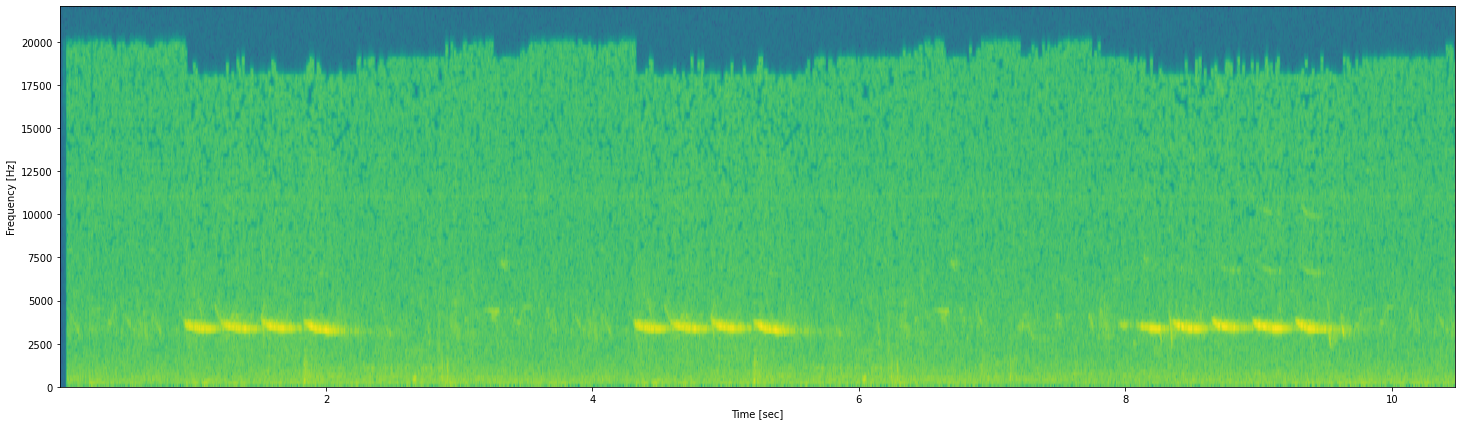

In [13]:
fig, ax = plt.subplots(figsize=(25,7))
Pxx, freqs, bins, im = plt.specgram(x = data, Fs=samplerate)

# add axis labels
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [14]:
trim_data, _ = librosa.effects.trim(data)
fig, ax = plt.subplots(figsize=(25,7))

librosa.display.waveplot(y = trim_data, sr = samplerate)

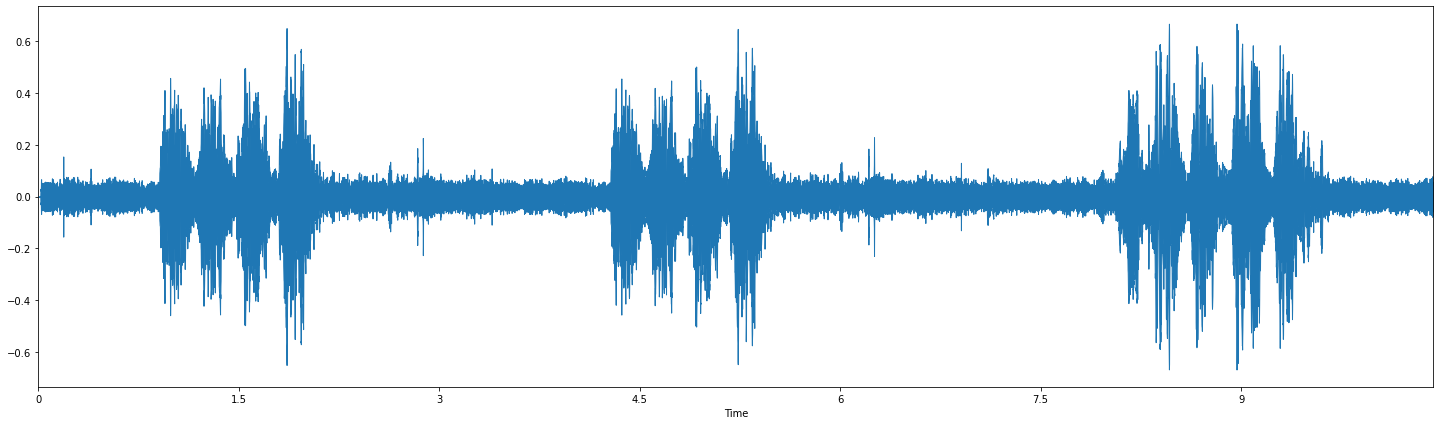

In [23]:
fig, ax = plt.subplots(figsize=(25,7))

librosa.display.waveplot(y = trim_data, sr = samplerate)

In [24]:
# Default FFT window size
n_fft = int(6.144000e+03) # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
FFT_data = np.abs(librosa.stft(trim_data, n_fft = n_fft, hop_length = hop_length))

In [25]:
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_data = librosa.amplitude_to_db(FFT_data, ref = np.max)

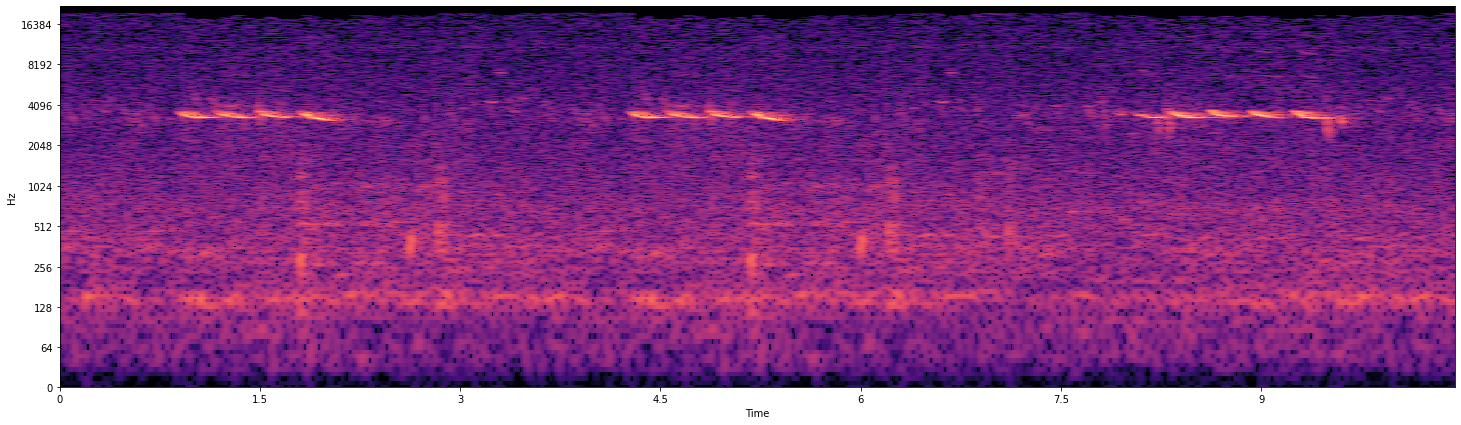

In [27]:
fig, ax = plt.subplots(figsize=(25,7))

librosa.display.specshow(DB_data, sr = samplerate, x_axis = 'time', 
                         y_axis = 'log', cmap = 'magma')

## Define a function to read the audiofiles and preprocess them

In [19]:
def load_audio(path, file_id):
    # Read the aufdiofile in format .flac
    data, samplerate = sf.read(path+ "/xc"+str(file_id)+".flac")
    # determine the duration of the file
    s = len(data)/samplerate
    # compute and extract the melspectrogram
    sg = librosa.feature.melspectrogram(data, sr=samplerate, hop_length=512)#"hope_length", from the documentation -> "number of samples between successive frames"
    
    # Take mean amplitude M from frame with highest energy
    centerpoint = np.argmax(sg.mean(axis=0))
    M = sg[:,centerpoint].mean()
    
    # Filter out all frames with energy less than 5% of M
    mask = sg.mean(axis=0)>=M/20

    audio_mask = np.zeros(len(data), dtype=bool)
    for i in range(0,len(mask)):
        audio_mask[i*512:] = mask[i]
    # return the mel-spect, filtered high-pass mel-spect mask, raw data, raw_data mask and samplerate
    return sg, mask, data, audio_mask, samplerate

In [20]:
# We create a Dictionary with files_ID keys containing the arrays with the filtered record of the audiosignal
# and populate a new column to the dataframe with the lenght (duration) of the audio audiosignal

df['length'] = np.zeros(len(df))

waves = {}


for file_id in df['file_id']:
    sg, mask, data, audio_mask, sample_rate = load_audio(path = audio_path, file_id = file_id)
    waves[file_id] = data[audio_mask]
    df.loc[df['file_id'] == file_id,'length'] = len(data[audio_mask])
#     print(len(data[audio_mask])/sample_rate)

In [5]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   file_id                 264 non-null    int64  
 1   genus                   264 non-null    object 
 2   species                 264 non-null    object 
 3   english_cname           264 non-null    object 
 4   who_provided_recording  264 non-null    object 
 5   country                 264 non-null    object 
 6   latitude                261 non-null    float64
 7   longitute               261 non-null    float64
 8   type                    264 non-null    object 
 9   license                 264 non-null    object 
dtypes: float64(2), int64(1), object(7)
memory usage: 20.8+ KB


<ipython-input-5-6ac79f7ef903>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose=True, null_counts=True)


In [ ]:
## df.loc[df['file_id'] == 132608,'length']

In [28]:
df

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,length
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,256512.0
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,52736.0
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,47104.0
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,152576.0
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,94720.0
...,...,...,...,...,...,...,...,...,...,...,...
259,132392,Turdus,philomelos,Song Thrush,david m,United Kingdom,54.1200,-0.5445,song,http://creativecommons.org/licenses/by-nc-nd/3.0/,847360.0
260,146756,Turdus,philomelos,Song Thrush,David Darrell-Lambert,United Kingdom,51.6608,0.0031,song,http://creativecommons.org/licenses/by-nc-sa/3.0/,251392.0
261,27060,Vanellus,vanellus,Northern Lapwing,Patrik berg,Sweden,58.4051,14.3028,song,http://creativecommons.org/licenses/by-nc-sa/3.0/,300032.0
262,97982,Vanellus,vanellus,Northern Lapwing,Herman van der Meer,Netherlands,52.1520,4.3470,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,325632.0


In [29]:

len(waves.keys())

264

In [24]:
waves.keys()

dict_keys([132608, 132611, 35068, 82715, 64685, 64686, 120664, 120666, 76767, 124052, 124053, 27999, 113082, 101371, 128853, 123169, 123170, 158166, 138979, 30614, 142431, 83705, 33395, 99299, 139552, 67307, 77645, 94584, 35578, 95381, 64738, 118363, 83894, 156388, 67229, 27039, 133880, 97792, 133886, 70129, 130409, 146753, 28961, 99155, 124013, 129576, 129577, 143894, 121691, 156262, 121735, 92264, 116226, 121677, 89994, 82971, 77429, 130993, 94614, 94615, 42224, 143170, 64735, 96464, 98400, 96133, 27145, 143002, 143005, 33392, 37447, 134671, 42178, 44203, 131316, 148465, 133444, 142697, 148528, 98172, 72629, 130426, 98942, 155975, 123168, 125777, 123167, 102106, 102107, 145533, 102048, 102803, 86327, 70124, 30390, 133862, 42803, 122548, 121597, 31059, 44707, 130639, 27080, 90977, 135270, 89530, 26789, 82701, 127136, 142908, 46223, 58571, 58573, 58579, 53817, 25754, 76241, 157322, 157331, 157279, 108002, 133054, 133471, 130283, 149806, 71943, 126481, 154285, 125486, 102060, 125782, 14

In [223]:
waves[146757].shape

(241664,)

###  Inspect the lenght of audio files

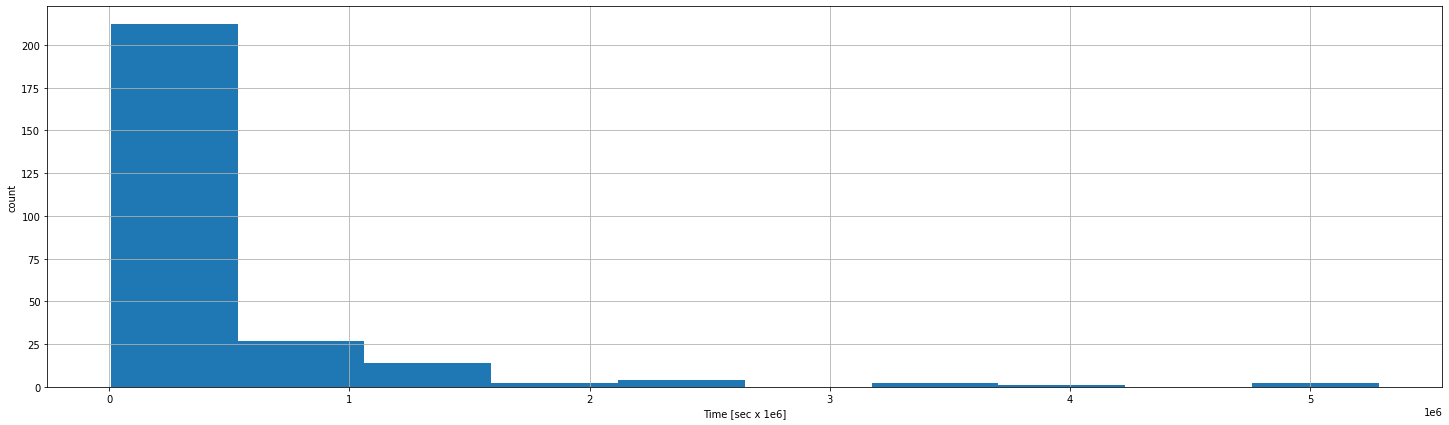

count    2.640000e+02
mean     4.307551e+05
std      6.611081e+05
min      6.144000e+03
25%      1.000960e+05
50%      2.373120e+05
75%      4.424960e+05
max      5.286262e+06
Name: length, dtype: float64

In [276]:
fig, ax = plt.subplots(figsize=(25,7))
df['length'].hist()
plt.ylabel('count')
plt.xlabel('Time [sec x 1e6]')
plt.show()

df['length'].describe()

In [32]:
# We set window to 6.144000e+03 frames as it's the minimum length among our audio files
df['windows'] = df['length'].apply(lambda x: int(x/6.144000e+03))
df.head()

,file_id,genus,species,english_cname,who_provided_recording,country,latitude,longitute,type,license,length,windows
0,132608,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"female, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,256512.0,41
1,132611,Acanthis,flammea,Common Redpoll,Jarek Matusiak,Poland,50.7932,15.4995,"flight call, male, song",http://creativecommons.org/licenses/by-nc-sa/3.0/,52736.0,8
2,35068,Acanthis,flammea,Common Redpoll,Sander Bot,Netherlands,52.8176,6.4326,"call, song",http://creativecommons.org/licenses/by-nc-nd/2.5/,47104.0,7
3,82715,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,152576.0,24
4,64685,Acrocephalus,palustris,Marsh Warbler,Dougie Preston,United Kingdom,60.3539,-1.2689,Song,http://creativecommons.org/licenses/by-nc-nd/2.5/,94720.0,15


In [277]:
#compute the sum of total windows for species
df.groupby(["genus",'species'])['windows'].sum().to_frame().sort_values("windows")

,,windows
genus,species,
Motacilla,flava,20
Perdix,perdix,23
Calidris,alpina,37
Sylvia,curruca,38
Muscicapa,striata,40
...,...,...
Locustella,fluviatilis,671
Chroicocephalus,ridibundus,777
Acrocephalus,schoenobaenus,1049


In [33]:
# We'll consider the genus + species as the label 
# We use 20 windows per genus + species to have a balanced data set

n_windows = df.groupby(["genus",'species'])['windows'].sum().min()
n_windows

20

In [34]:
# We create all windows for each file and partition them by species

windows = {}

for file_id in df['file_id']:
    wave = waves[file_id]
    species = df[df['file_id']==file_id]['genus'].values[0] + "_" + df[df['file_id']==file_id]['species'].values[0]
    if species not in windows:
        windows[species] = []
    for i in range(0, int(len(wave)/6.144000e+03)):
        windows[species].append(wave[i:int(i+6.144000e+03)])
        



In [37]:
# We randomly pick 20 windows for each species

# Save other samples for testing

windows_fixed = {}
windows_fixed_test = {}

for species in windows.keys():
    windows_fixed[species] = []
    windows_fixed_test[species] = []
    ws = windows[species]
    index = np.random.choice(len(ws), n_windows, replace=False)
    for i in range(0, len(ws)):
        if i in index:
            windows_fixed[species].append(ws[i])
        else:
            windows_fixed_test[species].append(ws[i])

# Spectral centroid
The spectral centroid is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.

*Source: Wikipedia*

## Visualizing the centroids for a given Window

In [40]:
def process_my_raw_data(data_array):
#     n_fft = int(6.144000e+03) # FFT window size
#     hop_length = 512 # number audio of frames between STFT columns (looks like a good default)
    FFT_data = np.abs(librosa.stft(data_array))
    DB_data = librosa.amplitude_to_db(FFT_data, ref = np.max)
    return (DB_data)
    

In [41]:
# Take a given window from the fixed Window_20
my_window_indx = 15
my_species_name = "Poecile_montanus"
my_window = windows_fixed[my_species_name][my_window_indx]

/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


[Text(0.5, 1.0, 'log Power spectrogram')]

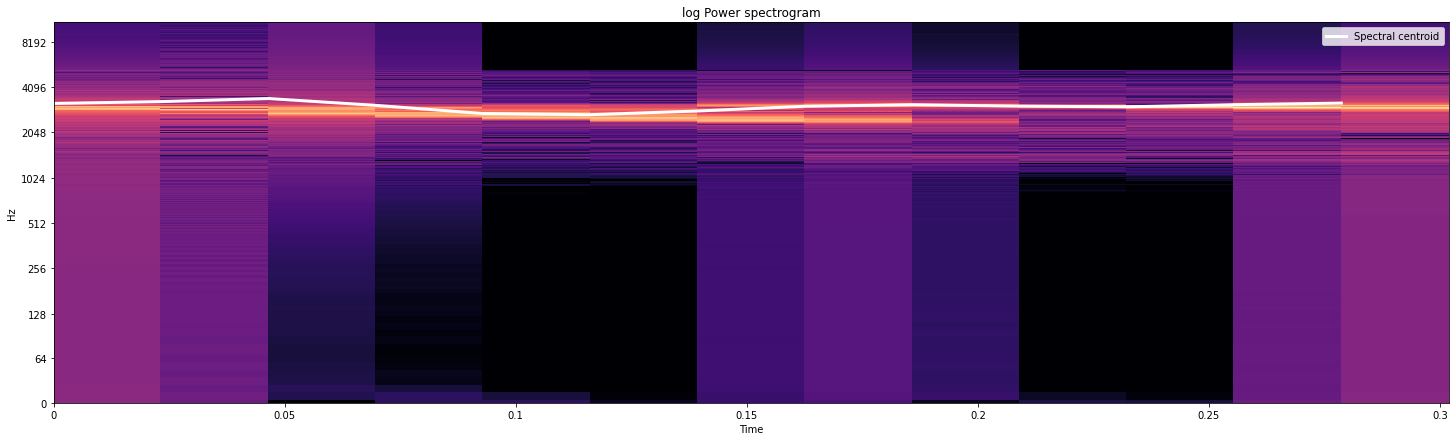

In [42]:
# Compute short time Fourier transforms and stract magnitude (S) component
S, _ = librosa.magphase(librosa.stft(y=my_window))
# compute the centroid
cent = librosa.feature.spectral_centroid(S=S)
# fix the time to be in s
times = librosa.times_like(cent)


fig, ax = plt.subplots(figsize=(25,7))

librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max), 
                         y_axis='log', 
                         x_axis='time',
                         cmap = 'magma',
                         ax=ax)

ax.plot(times, cent.T, label='Spectral centroid', color='w', linewidth= 3)

ax.legend(loc='upper right')

ax.set(title='log Power spectrogram')

# Chroma feature
In Western music, the term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized (often into twelve categories) and whose tuning approximates to the equal-tempered scale. One main property of chroma features is that they capture **harmonic** and **melodic** characteristics of music, while being robust to changes in timbre and instrumentation. 

*Source: Wikipedia*

## Visualizing the chroma spectrum for a given Window



/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


[Text(0.5, 1.0, 'Chromagram')]

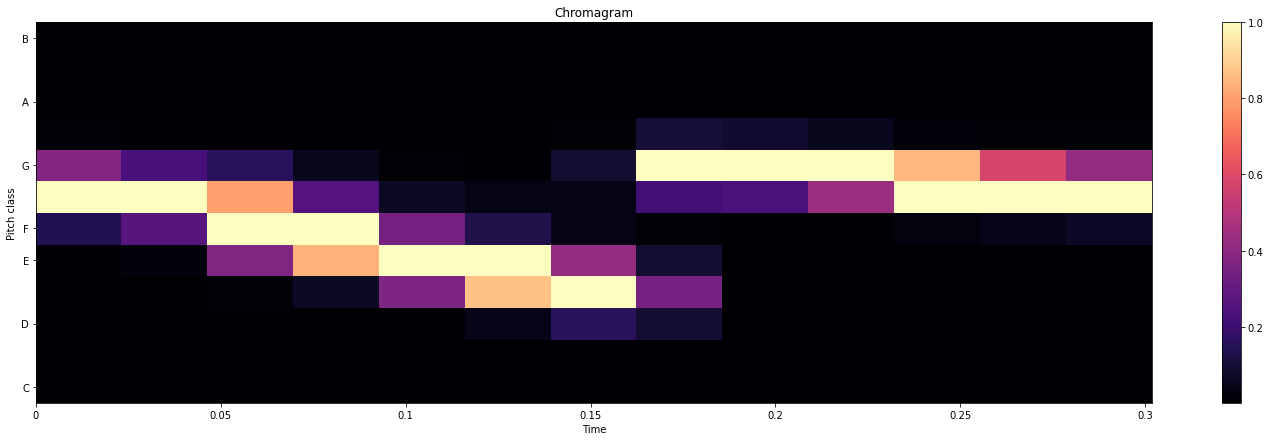

In [43]:
fig, ax = plt.subplots(figsize=(25,7))

chroma = librosa.feature.chroma_stft(y=my_window, sr=sample_rate)
img = librosa.display.specshow(chroma, 
                               y_axis='chroma', 
                               x_axis='time',
                               cmap = 'magma',
                               ax=ax)

fig.colorbar(img, ax=ax)

ax.set(title='Chromagram')

#  Extracting features

In [ ]:
# Extract Features from fixed Window (20)

new_dataset = pd.DataFrame()# this is the same as train.csv dataset

for species in windows_fixed.keys():
    for i in range(0,n_windows):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = librosa.feature.spectral_centroid(windows_fixed[species][i])[0]
        chroma = librosa.feature.chroma_stft(windows_fixed[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset = new_dataset.append(data_point,ignore_index=True)

new_dataset["id"] =np.arange(len(new_dataset))
new_dataset.head()

In [271]:
# Extract Features from Window for test

new_dataset_test = pd.DataFrame()# this is the same as test.csv

for species in windows_fixed_test.keys():
    for i in range(0,len(windows_fixed_test[species])):
        data_point = {'species':species.split('_')[1], 'genus':species.split('_')[0]}
        spec_centroid = librosa.feature.spectral_centroid(windows_fixed_test[species][i])[0]
        chroma = librosa.feature.chroma_stft(windows_fixed_test[species][i], sample_rate)
        for j in range(0,13):
            data_point['spec_centr_'+str(j)] = spec_centroid[j]
            for k in range(0,12):
                data_point['chromogram_'+str(k)+"_"+str(j)] = chroma[k,j]
        new_dataset_test = new_dataset_test.append(data_point,ignore_index=True)

new_dataset_test["id"] =np.arange(len(new_dataset_test))
new_dataset_test.head()

/Users/rubencito/.pyenv/versions/3.8.8/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


,chromogram_0_0,chromogram_0_1,chromogram_0_10,chromogram_0_11,chromogram_0_12,chromogram_0_2,chromogram_0_3,chromogram_0_4,chromogram_0_5,chromogram_0_6,...,spec_centr_2,spec_centr_3,spec_centr_4,spec_centr_5,spec_centr_6,spec_centr_7,spec_centr_8,spec_centr_9,species,id
0,1.000000,0.945011,0.749241,0.714737,0.704973,0.311386,0.881971,0.280575,0.519973,0.170108,...,2731.690852,2611.073050,2702.003239,2675.278371,2817.586465,2708.632712,2738.029229,2688.206937,flammea,0
1,0.982724,0.826884,0.768729,0.702757,0.662904,0.328242,0.924370,0.311240,0.492785,0.167188,...,2731.110902,2610.496832,2702.711165,2675.828996,2817.996189,2707.371617,2739.432407,2686.417165,flammea,1
2,1.000000,0.945205,0.744401,0.716860,0.701898,0.315170,0.885456,0.275877,0.519047,0.170131,...,2730.815328,2610.216159,2703.054777,2676.112022,2818.189758,2706.744518,2740.128437,2685.521405,flammea,2
3,1.000000,0.904057,0.749178,0.708311,0.676811,0.318977,0.899720,0.284723,0.506305,0.168488,...,2730.666134,2610.077572,2703.223991,2676.255550,2818.283776,2706.431856,2740.475063,2685.073264,flammea,3
4,0.997944,0.832392,0.765386,0.704275,0.655724,0.331064,0.927524,0.307601,0.492226,0.167480,...,2730.515996,2609.940116,2703.391481,2676.400498,2818.375970,2706.119790,2740.820758,2684.624943,flammea,4
